In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda, Resize
from medmnist import INFO, TissueMNIST
from transformers import ViTForImageClassification
from transformers import AdamW

def load_data(data_flag='tissuemnist', batch_size=16):
    n_classes = len(INFO[data_flag]['label'])
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Lambda(lambda x: x.repeat(3, 1, 1)),
        Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

    train_dataset = TissueMNIST(split='train', transform=transform, download=True)
    val_dataset = TissueMNIST(split='val', transform=transform, download=True)
    test_dataset = TissueMNIST(split='test', transform=transform, download=True)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, n_classes

def setup_model(n_classes):
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=n_classes)
    return model

def train_and_evaluate(model, train_loader, val_loader, device):
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    best_accuracy = 0
    best_model_path = 'best_model.pth'

    model.train()
    for epoch in range(10):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze(1).long()

            outputs = model(images).logits
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        total, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.squeeze(1).long()

                outputs = model(images).logits
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Accuracy: {accuracy}%')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with accuracy: {accuracy}% at epoch {epoch+1}")

    print(f'Training complete. Best model was saved with an accuracy of {best_accuracy}%.')




def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_loader, val_loader, test_loader, n_classes = load_data()
    model = setup_model(n_classes)
    train_and_evaluate(model, train_loader, val_loader, device)

if __name__ == '__main__':
    main()



Using downloaded and verified file: C:\Users\metho\.medmnist\tissuemnist.npz
Using downloaded and verified file: C:\Users\metho\.medmnist\tissuemnist.npz
Using downloaded and verified file: C:\Users\metho\.medmnist\tissuemnist.npz


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\metho\anaconda3\Lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.757739245891571, Validation Accuracy: 67.2673434856176%
Best model saved with accuracy: 67.2673434856176% at epoch 1
Epoch 2, Loss: 1.0797791481018066, Validation Accuracy: 69.45008460236886%
Best model saved with accuracy: 69.45008460236886% at epoch 2
Epoch 3, Loss: 0.826302170753479, Validation Accuracy: 70.09729272419628%
Best model saved with accuracy: 70.09729272419628% at epoch 3
Epoch 4, Loss: 1.204735279083252, Validation Accuracy: 71.02368866328257%
Best model saved with accuracy: 71.02368866328257% at epoch 4
Epoch 5, Loss: 0.17441539466381073, Validation Accuracy: 70.86294416243655%
Epoch 6, Loss: 0.491341769695282, Validation Accuracy: 68.73942470389171%
Epoch 7, Loss: 0.059316884726285934, Validation Accuracy: 69.12013536379018%
Epoch 8, Loss: 0.09050990641117096, Validation Accuracy: 68.41793570219966%
Epoch 9, Loss: 0.2674834728240967, Validation Accuracy: 69.10321489001691%
Epoch 10, Loss: 0.08478870987892151, Validation Accuracy: 68.72250423011845%
Tr

Using downloaded and verified file: C:\Users\metho\.medmnist\tissuemnist.npz


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy: 71.45727580372251%
Confusion Matrix:
 [[12815   315    25   239   233    81   776   681]
 [  895   820    13    48    67    24   133   233]
 [   25     2   971   148   223   301     5     2]
 [  197    18   141  2962   772   144   120    48]
 [  170    27   124   374  2387   109   118    60]
 [  120     4   362   177   259  1185    57    38]
 [ 1336   125    21   327   205   135  8003  1049]
 [ 1088   171    10   146   146    58   770  4642]]
Shape of Confusion Matrix: (8, 8)


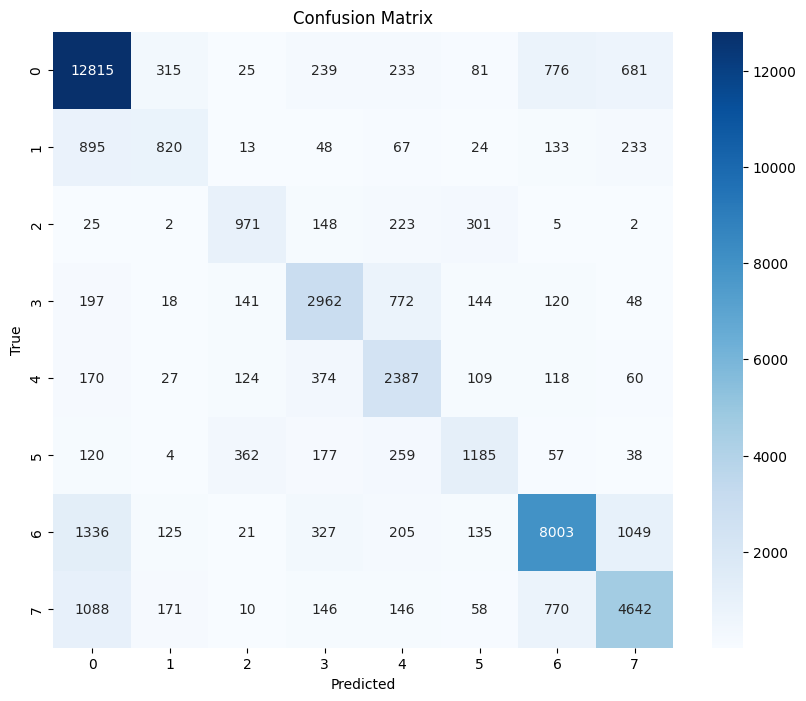


Classification Report:

              precision    recall  f1-score   support

           0     0.7699    0.8450    0.8057     15165
           1     0.5533    0.3672    0.4415      2233
           2     0.5825    0.5790    0.5807      1677
           3     0.6700    0.6729    0.6714      4402
           4     0.5562    0.7085    0.6232      3369
           5     0.5817    0.5381    0.5591      2202
           6     0.8017    0.7145    0.7556     11201
           7     0.6874    0.6602    0.6735      7031

    accuracy                         0.7146     47280
   macro avg     0.6503    0.6357    0.6388     47280
weighted avg     0.7150    0.7146    0.7120     47280



In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda, Resize
from medmnist import TissueMNIST
from transformers import ViTForImageClassification
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def load_test_data(batch_size=16):
    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat the grayscale image to 3 channels
        Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    test_dataset = TissueMNIST(split='test', transform=transform, download=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader

def load_model(n_classes, model_path='best_model.pth'):
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=n_classes)
    model.load_state_dict(torch.load(model_path))
    return model

def evaluate(model, test_loader, device):
    model.to(device)
    model.eval()

    total, correct = 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze(1).long()  # Ensure labels are in the correct format

            outputs = model(images).logits
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}%')

    return all_labels, all_preds

def plot_confusion_matrix(labels, preds, n_classes):
    cm = confusion_matrix(labels, preds, labels=range(n_classes))
    print("Confusion Matrix:\n", cm)  # Add this line for debugging
    print("Shape of Confusion Matrix:", cm.shape)  # Add this line for debugging
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(n_classes), yticklabels=range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def print_classification_report(labels, preds):
    report = classification_report(labels, preds, digits=4)
    print("\nClassification Report:\n")
    print(report)

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_loader = load_test_data()
    n_classes = 8  # Update this if the number of classes changes
    model = load_model(n_classes)
    labels, preds = evaluate(model, test_loader, device)
    plot_confusion_matrix(labels, preds, n_classes)
    print_classification_report(labels, preds)

if __name__ == '__main__':
    main()
